In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.spines import Spine
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Checking the data for nulls and outliers

In [ ]:
fish = pd.read_csv("Fish.csv")

In [ ]:
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [ ]:
print(fish.info())
print(fish.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None
Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


In [ ]:
fish.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [ ]:
fish.groupby('Species').describe().iloc[:,0:8]

Weight                                                         \
           count        mean         std    min     25%     50%     75%   
Species                                                                   
Bream       35.0  617.828571  209.205709  242.0  462.50  610.00  717.00   
Parkki      11.0  154.818182   78.755086   55.0  105.00  145.00  185.00   
Perch       56.0  382.239286  347.617717    5.9  120.00  207.50  692.50   
Pike        17.0  718.705882  494.140765  200.0  345.00  510.00  950.00   
Roach       20.0  152.050000   88.828916    0.0  104.25  147.50  171.75   
Smelt       14.0   11.178571    4.131526    6.7    8.95    9.85   12.20   
Whitefish    6.0  531.000000  309.602972  270.0  279.00  423.00  735.00   

                   
              max  
Species            
Bream      1000.0  
Parkki      300.0  
Perch      1100.0  
Pike       1650.0  
Roach       390.0  
Smelt        19.9  
Whitefish  1000.0

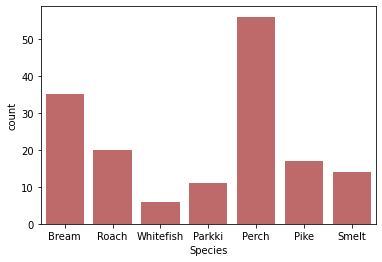

In [ ]:
sns.countplot(data = fish, x = 'Species', color = 'indianred',dodge = False)

**Pikes in partciular appear to have a different trend (more linear) than the rest of the fish. It would ideally be best to make two models, one for pikes and one for the remaining species. However, that will not be done in this analysis. Pikes are also a cause for the outliers shifting the model.**

In [ ]:
species = np.unique(np.array(fish['Species']).reshape(-1,1))
species

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

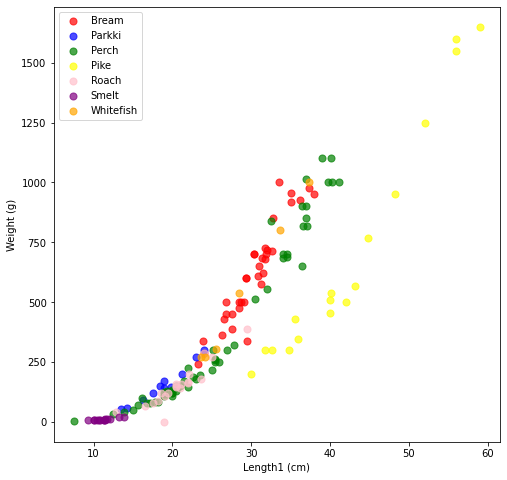

In [ ]:
species_ = np.unique(np.array(fish['Species']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(8,8))
colors = ['red','blue','green','yellow','pink','purple','orange']
for s, color in zip(species_, colors):
    id = np.where(fish['Species'] == s)
    ax.scatter(
        fish['Length1'].values[id], fish['Weight'].values[id], label=species,
        s=50, color=color, alpha=0.7
    )
ax.set_xlabel("Length1 (cm)")
ax.set_ylabel("Weight (g)")
ax.legend(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish']);

**There are no nulls/na's in the data, with outliers apparent by looking at the summary statistics. There is a problem with co linearity, to deal with this only one length variable will be used. All other variables correlations will be below 0.9**

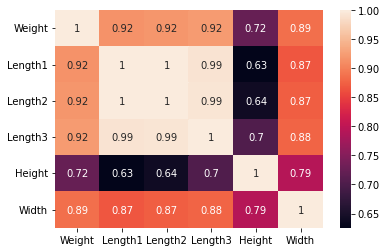

In [ ]:
sns.heatmap(data = fish.corr(), annot = True)

**Below shows that fish weight has a heavy right skew distribution. While the other variables are more normally distributed with slight right tails. Specific features like length(1-3) follow the results of the obvious outliers present. The outliers however do follow a linear/quadratic relationship among the main predictors.**

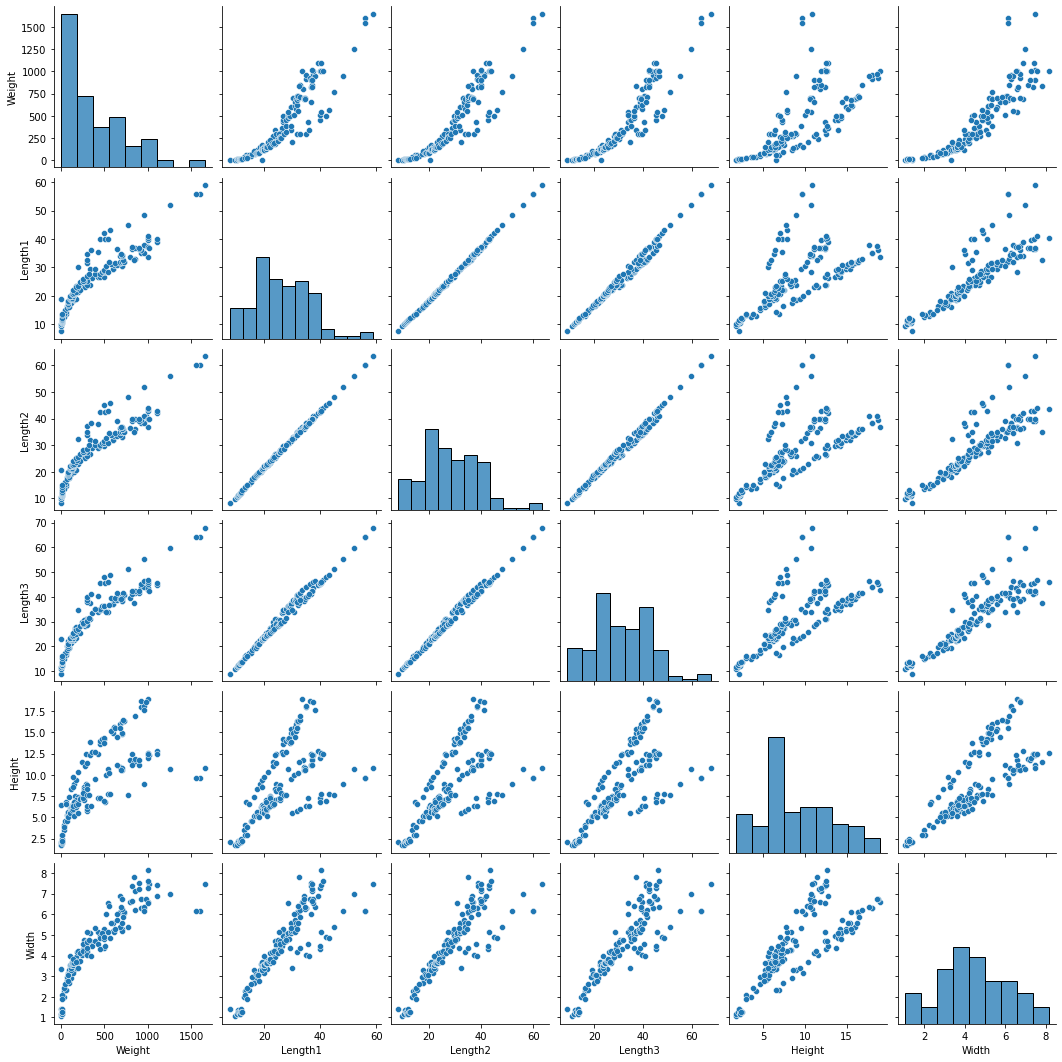

In [ ]:
sns.pairplot(fish)

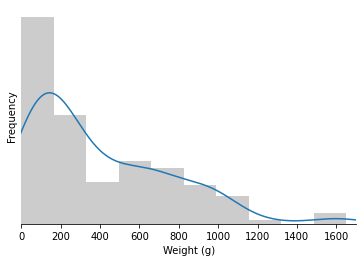

In [ ]:
ax = plt.axes()
fish['Weight'].plot(kind = "hist", density = True, alpha = 0.2, color = 'black', bins = 10)
fish['Weight'].plot(kind = "kde")
ax.set_facecolor('white')
plt.xlim(0,1700)
plt.xlabel("Weight (g)")
plt.ylabel("Frequency")
plt.yticks([])
sns.despine(top=True, right=True, left=True, bottom=False)

# Linear Model

**Linear model with all variables.**

In [ ]:
s = ['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish']
values = [1]
for i in range(0,len(s)):
  conditions = [(fish['Species'] == s[i])]
  fish[s[i]] = np.select(conditions,values)
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


In [ ]:
X = fish[['Length1','Length2','Length3','Height','Width','Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish']]
y = fish['Weight']
reg = LinearRegression()
reg.fit(X,y)
print("The r squared is ",reg.score(X,y))
print("The coefficients are ",reg.coef_)
print("The intercept is ",reg.intercept_)
print("The MSE is ", mean_squared_error(reg.predict(X),y))

The r squared is  0.9360849020585846
The coefficients are  [ -80.30295196   79.88863137   32.53538142    5.25098766   -0.51543798
 -105.31852197   59.4041387    32.63038766 -313.74787858   -2.2785674
  340.75479551  -11.44435392]
The intercept is  -813.0136182332824
The MSE is  8139.1089903368


**From the cell below not all variables are significant due to colinearity, which is to be expected.**

In [ ]:
X2 = sm.add_constant(X)
m = sm.OLS(y,X2)
m = m.fit()
m.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     195.7
Date:                Wed, 18 May 2022   Prob (F-statistic):           6.85e-82
Time:                        19:01:30   Log-Likelihood:                -941.46
No. Observations:                 159   AIC:                             1907.
Df Residuals:                     147   BIC:                             1944.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -711.3869     47.172    -15.081      0.000    -804.611    -618.163
Length1      -80.3030     36.279     -2.214      0.028    -151.998      -8.608
Length2       79.8886     45.718      1.747      0.083     -10.461     170.238
Length3       32.5354     29.300      1.110      0.269     -25.369      90.439
Height         5.2510     13.056      0.402      0.688     -20.551      31.053
Width         -0.5154     23.913     -0.022      0.983     -47.773      46.742
Bream       -206.9452     89.978     -2.300      0.023    -384.762     -29.128
Parkki       -42.2226     41.601     -1.015      0.312    -124.436      39.991
Perch        -68.9963     37.083     -1.861      0.065    -142.281       4.288
Pike        -415.3746     69.881     -5.944      0.000    -553.476    -277.273
Roach       -103.9053     24.123     -4.307      0.000    -151.578     -56.232
Smelt        239.1281     38.181      6.263      0.000     163.674     314.582
Whitefish   -113.0711     38.588     -2.930      0.004    -189.330     -36.812
==============================================================================
Omnibus:                       43.558   Durbin-Watson:                   0.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.422
Skew:                           1.184   Prob(JB):                     7.00e-22
Kurtosis:                       6.016   Cond. No.                     1.01e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.53e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Test model with removed variables of colinearity, creating dummy variables bsed off species.**

In [ ]:
features = fish[['Length1','Width','Height','Bream','Parkki','Perch','Pike','Roach','Smelt','Whitefish']]
x_train, x_test, y_train, y_test = train_test_split(features,fish['Weight'], test_size = 0.3, random_state = 1)

In [ ]:
model = LinearRegression()
model.fit(x_train,y_train)
print("The R squared is",r2_score(model.predict(x_train),y_train))
print("The mean squared error is",mean_squared_error(model.predict(x_train),y_train))

The R squared is 0.9331607088563953
The mean squared error is 8213.582922825124


**Test set**

In [ ]:
print("The R squared is",r2_score(model.predict(x_test),y_test))
print("The mean squared error is",mean_squared_error(model.predict(x_test),y_test))

The R squared is 0.8836915479473776
The mean squared error is 11176.029592970983


**Measuring the model using cross validation with R squared and negative mean squared error.**

In [ ]:
cv = KFold(n_splits = 8, shuffle = True, random_state = 1)
score = cross_val_score(model,features,fish['Weight'],scoring = 'r2', cv = cv)

In [ ]:
print(score)
print(np.mean(score))

[0.85567959 0.92452563 0.82816179 0.97557365 0.94762384 0.96417138
 0.94688264 0.86419864]
0.9133521426382705


In [ ]:
error = cross_val_score(model,features,fish['Weight'],scoring = 'neg_mean_squared_error', cv = cv)

In [ ]:
print(error)
print(np.mean(error))

[-10408.55382662 -12664.17934513 -11133.69560141  -3749.61175107
  -5953.91179178  -3770.11105381  -5765.40969686 -29167.45121775]
-10326.615535555207


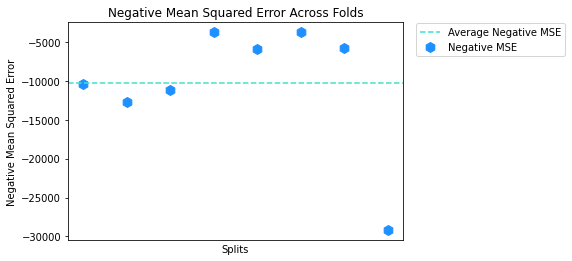

In [ ]:
series_rsquared = pd.Series(score)
series_error = pd.Series(error)
plt.scatter(np.linspace(0,8,8),series_error, s = 100, marker = 'h', c = 'dodgerblue')
plt.ylabel("Negative Mean Squared Error")
plt.title("Negative Mean Squared Error Across Folds")
plt.xticks([])
plt.axhline(y=np.mean(error), color='turquoise', linestyle='--')
plt.xlabel("Splits")
plt.legend(["Average Negative MSE", "Negative MSE"], loc='upper right', bbox_to_anchor=(1.50, 1.02))

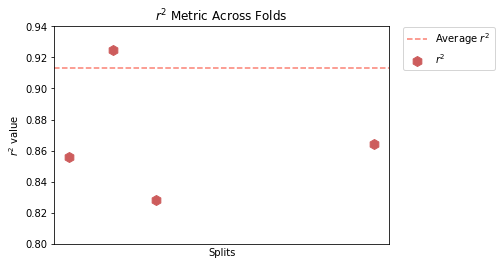

In [ ]:
plt.scatter(np.linspace(0,8,8),series_rsquared, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(score), color = 'salmon', linestyle = '--')
plt.xlabel("Splits")
plt.ylabel("$r^2$ value")
plt.title("$r^2$ Metric Across Folds")
plt.xticks([])
plt.ylim(0.8,0.94)
plt.legend(["Average $r^2$", "$r^2$"], loc='upper right', bbox_to_anchor=(1.33, 1.02))

# Transformation

**Based on the pattern between length1 and weight, which we have determined as the main driving predictor a square root transformation is applied.**

In [ ]:
model_trans = LinearRegression()
model_trans.fit(x_train,y_train**0.5)
print("The R squared is",r2_score(model_trans.predict(x_train),y_train**0.5))
print("The mean squared error is",mean_squared_error(model_trans.predict(x_train),y_train**0.5))

The R squared is 0.9884325552215851
The mean squared error is 0.986083305492255


In [ ]:
print("The R squared is",r2_score(model_trans.predict(x_test),y_test**0.5))
print("The mean squared error is",mean_squared_error(model_trans.predict(x_test),y_test**0.5))

The R squared is 0.9467874243613534
The mean squared error is 3.7032120217029547


**The difference in r squared is close to 10% on average on both the train and test set, a signficant increase from before. The cross validation below shows that this holds true for almost all folds, with one outlier in which the transformation behaved weaker.**

In [ ]:
score_trans = cross_val_score(model,features,fish['Weight']**0.5,scoring = 'r2', cv = cv)
print(score_trans)

[0.88474102 0.98092265 0.96482605 0.99282806 0.99262422 0.99258809
 0.99265907 0.97681802]


In [ ]:
error_trans = cross_val_score(model,features,fish['Weight']**0.5,scoring = 'neg_mean_squared_error', cv = cv)
print(error_trans)

[-6.79480851 -1.85969068 -2.08134328 -0.73713686 -0.5557354  -0.60551876
 -0.66066496 -2.2885767 ]


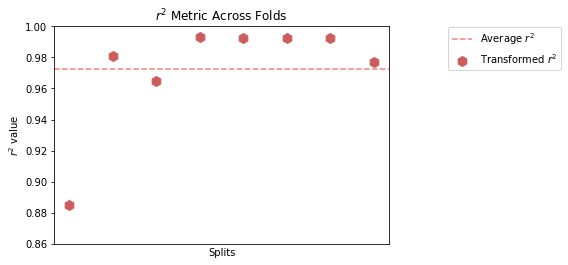

In [ ]:
plt.scatter(np.linspace(0,8,8), score_trans, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(score_trans), color = 'salmon', linestyle = '--')
plt.xlabel("Splits")
plt.ylabel("$r^2$ value")
plt.title("$r^2$ Metric Across Folds")
plt.xticks([])
plt.ylim(0.86,1)
plt.legend(["Average $r^2$", "Transformed $r^2$"], loc='upper right', bbox_to_anchor=(1.53, 1.02))


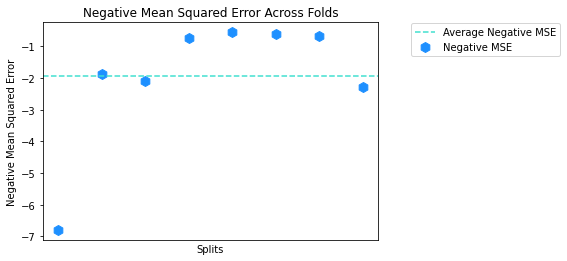

In [ ]:
plt.scatter(np.linspace(0,8,8),error_trans, s = 100, marker = 'h', c = 'dodgerblue')
plt.ylabel("Negative Mean Squared Error")
plt.title("Negative Mean Squared Error Across Folds")
plt.xticks([])
plt.axhline(y=np.mean(error_trans), color='turquoise', linestyle='--')
plt.xlabel("Splits")
plt.legend(["Average Negative MSE", "Negative MSE"], loc='upper right', bbox_to_anchor=(1.56, 1.02))

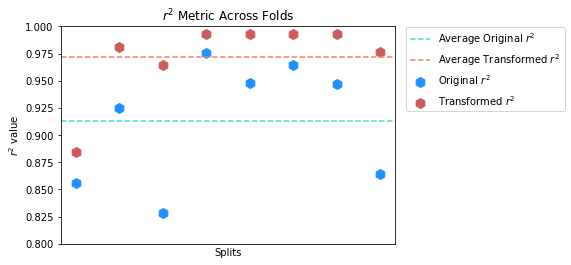

In [ ]:
plt.scatter(np.linspace(0,8,8),series_rsquared, color = 'dodgerblue', s = 100, marker = 'h')
plt.axhline(y = np.mean(score), color = 'turquoise', linestyle = '--')
plt.scatter(np.linspace(0,8,8), score_trans, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(score_trans), color = 'salmon', linestyle = '--')
plt.xlabel("Splits")
plt.ylabel("$r^2$ value")
plt.ylim(0.8,1)
plt.title("$r^2$ Metric Across Folds")
plt.xticks([])
plt.legend(["Average Original $r^2$", "Average Transformed $r^2$", "Original $r^2$", "Transformed $r^2$"], loc='upper right', bbox_to_anchor=(1.52, 1.02))

# Ridge Regression

In [ ]:
ridge_train_pred = []
ridge_test_pred = []
for alpha in np.arange(0, 200, 1):
    # training
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(x_train, y_train)
    ridge_train_pred.append(ridge_reg.predict(x_train))
    ridge_test_pred.append(ridge_reg.predict(x_test))

**The test set appears to have optimal measurements at around the original model.**

Text(0, 0.5, 'MSE')

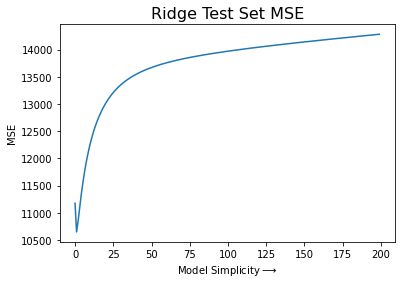

In [ ]:
ridge_mse_train = [mean_squared_error(y_test, p) for p in ridge_test_pred]

plt.plot(ridge_mse_train[:200])
plt.title("Ridge Test Set MSE", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("MSE")

Text(0, 0.5, '$r^2$')

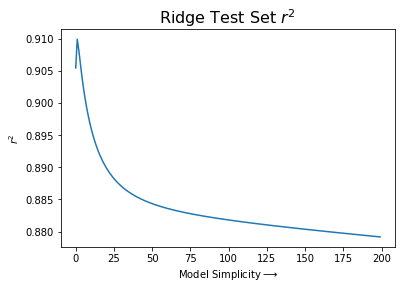

In [ ]:
ridge_r2_test = [r2_score(y_test, p) for p in ridge_test_pred]

# plot mse
plt.plot(ridge_r2_test[:200])
plt.title("Ridge Test Set $r^2$", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("$r^2$")

**Cross evaluation results for ridge regression.**

In [ ]:
ridge_cross_r2 = []
ridge_cross_error = []
for alpha in np.arange(0, 200, 1):
    # training
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(x_train, y_train)
    score = cross_val_score(ridge_reg,features,fish['Weight'], scoring = 'r2', cv = cv)
    error = cross_val_score(ridge_reg,features,fish['Weight'], scoring = 'neg_mean_squared_error', cv = cv)
    ridge_cross_r2.append(np.mean(score))
    ridge_cross_error.append(np.mean(error))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.50805e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.44603e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.65143e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.50805e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

Text(0, 0.5, '$r^2$')

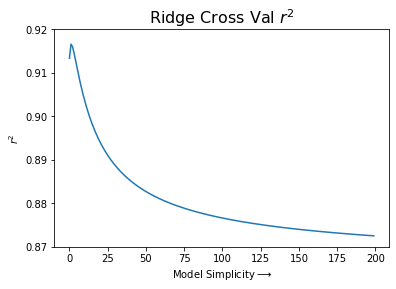

In [ ]:
plt.plot(ridge_cross_r2[:200])
plt.title("Ridge Cross Val $r^2$", fontsize=16)
plt.ylim(0.87,0.92)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("$r^2$")

Text(0, 0.5, 'MSE')

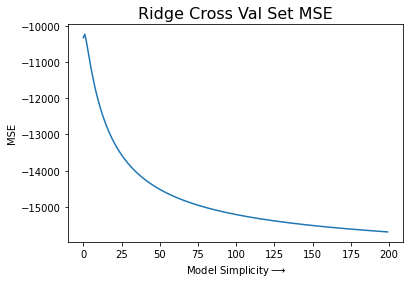

In [ ]:
plt.plot(ridge_cross_error[:200])
plt.title("Ridge Cross Val Set MSE", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("MSE")

In [ ]:
print(np.max(ridge_cross_r2))
print(ridge_cross_r2)

0.9165934388563088
[0.9133521426382702, 0.9165934388563088, 0.916002607240423, 0.914540799056857, 0.9128337900989293, 0.9110939736639336, 0.9094042104759545, 0.9077972364663698, 0.9062841445004606, 0.9048661478822206, 0.9035399008734797, 0.9023000528543222, 0.9011405189400291, 0.9000551202719245, 0.8990379018696475, 0.8980832810093635, 0.8971861053009289, 0.8963416627409304, 0.8955456668269048, 0.8947942295112921, 0.8940838290963986, 0.8934112769836917, 0.89277368537687, 0.8921684369991746, 0.8915931572909461, 0.8910456892171521, 0.8905240706295316, 0.8900265140316765, 0.889551388550951, 0.8890972039067129, 0.8886625961667125, 0.888246315094941, 0.8878472129099519, 0.8874642342899839, 0.8870964074785546, 0.8867428363606706, 0.8864026933950255, 0.8860752133013109, 0.8857596874140787, 0.885455458625483, 0.8851619168488192, 0.8848784949431905, 0.8846046650469872, 0.8843399352742762, 0.884083846733807, 0.8838359708352088, 0.8835959068512214, 0.8833632797084994, 0.8831377379827794, 0.882918

In [ ]:
ridge_a = Ridge(alpha = 1)
ridge_a.fit(x_train,y_train)
print(ridge_a.coef_)
print(r2_score(ridge_a.predict(x_train),y_train))
print(r2_score(ridge_a.predict(x_test),y_test))

[  32.95929664   26.2505315    10.08569906  -30.05742656   34.30298156
    9.62253342 -222.92703537  -18.8253452   222.80428975    5.08000239]
0.9291756166488541
0.8886203001193439


# Transformation on Ridge model

**Appying the same square root transformation as before on the dependent variable. We want to see if ridge regression can give a less overfit model to the training data, resulting in a higher r squared.**

In [ ]:
ridge_cross_r2_trans = []
ridge_cross_error_trans = []
for alpha in np.arange(0, 200, 1):
    ridge_reg_trans = Ridge(alpha=alpha)
    ridge_reg_trans.fit(x_train, y_train**0.5)
    score = cross_val_score(ridge_reg_trans,features,fish['Weight']**0.5, scoring = 'r2', cv = cv)
    error = cross_val_score(ridge_reg_trans,features,fish['Weight']**0.5, scoring = 'neg_mean_squared_error', cv = cv)
    ridge_cross_r2_trans.append(np.mean(score))
    ridge_cross_error_trans.append(np.mean(error))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.50805e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.44603e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.65143e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.50805e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

Text(0, 0.5, '$r^2$')

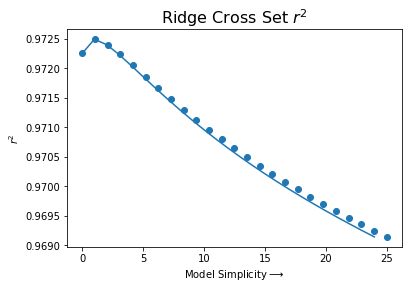

In [ ]:
plt.plot(ridge_cross_r2_trans[:25])
plt.scatter(np.linspace(0,25,25),ridge_cross_r2_trans[:25])
plt.title("Ridge Cross Set $r^2$", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("$r^2$")

In [ ]:
ridge_final = Ridge(alpha = 1)
ridge_final.fit(x_train, y_train**0.5)
print(ridge_final.coef_)
print(ridge_final.intercept_)
print(r2_score(ridge_final.predict(x_train),y_train**0.5))
print(r2_score(ridge_final.predict(x_test),y_test**0.5))

[ 0.58911157  1.2293829   0.55489358 -0.71147821  0.2133837   0.33441583
 -2.09460707 -0.14354396  1.57655597  0.82527375]
-8.029102414948454
0.9881323305040696
0.9468899863080366


In [ ]:
ridge_score_trans = cross_val_score(ridge_final, features, fish['Weight']**0.5, scoring = 'r2', cv = cv)
ridge_score_trans

array([0.88557843, 0.98059643, 0.96720216, 0.99308041, 0.9927003 ,
       0.99242073, 0.99211047, 0.97623364])

In [ ]:
ridge_error_trans = cross_val_score(ridge_final, features, fish['Weight']**0.5, scoring = 'neg_mean_squared_error', cv = cv)
ridge_error_trans

array([-6.74544119, -1.89149042, -1.94074196, -0.71119996, -0.5500034 ,
       -0.61919186, -0.71003758, -2.34626751])

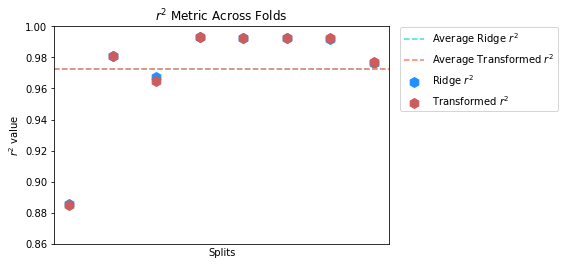

In [ ]:
plt.scatter(np.linspace(0,8,8),ridge_score_trans, color = 'dodgerblue', s = 100, marker = 'h')
plt.axhline(y = np.mean(ridge_score_trans), color = 'turquoise', linestyle = '--')
plt.scatter(np.linspace(0,8,8), score_trans, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(score_trans), color = 'salmon', linestyle = '--')
plt.xlabel("Splits")
plt.ylabel("$r^2$ value")
plt.ylim(0.86,1)
plt.title("$r^2$ Metric Across Folds")
plt.xticks([])
plt.legend(["Average Ridge $r^2$", "Average Transformed $r^2$", "Ridge $r^2$", "Transformed $r^2$"], loc='upper right', bbox_to_anchor=(1.52, 1.02))

In [ ]:
np.mean(ridge_score_trans) - np.mean(score_trans)

0.0002394240420803273

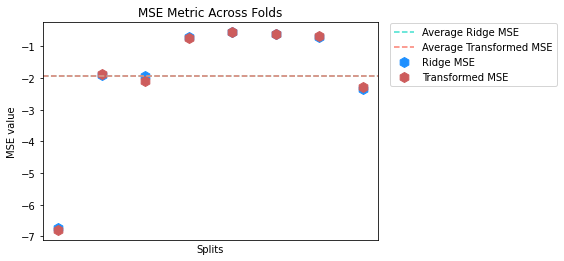

In [ ]:
plt.scatter(np.linspace(0,8,8),ridge_error_trans, color = 'dodgerblue', s = 100, marker = 'h')
plt.axhline(y = np.mean(ridge_error_trans), color = 'turquoise', linestyle = '--')
plt.scatter(np.linspace(0,8,8), error_trans, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(error_trans), color = 'salmon', linestyle = '--')
plt.xlabel("Splits")
plt.ylabel("MSE value")
plt.title("MSE Metric Across Folds")
plt.xticks([])
plt.legend(["Average Ridge MSE", "Average Transformed MSE", "Ridge MSE", "Transformed MSE"], loc='upper right', bbox_to_anchor=(1.55, 1.02))

**Overall ridge regression did not provide a signifcant increase compared to the original transformed model.**

# Polynomial Regression

**Degree 6 appears to capture the trend of that data, however due to the pike species the accuracy of the model is decreased.**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


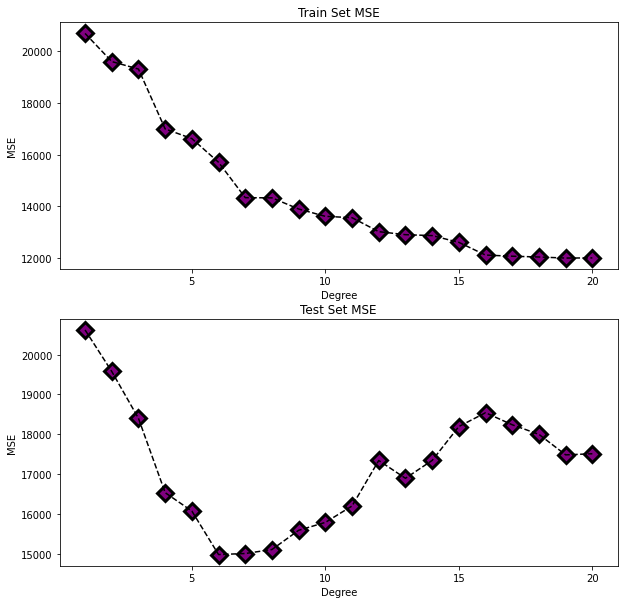

In [ ]:
x_train_poly, x_test_poly, y_train_poly, y_test_poly = train_test_split(fish['Length1'], fish['Weight'], test_size = 0.3, random_state = 1)

train_mse = []
test_mse = []
model = 20
fig, axs = plt.subplots(2,1,figsize = (10,10))
axs[0].set_title("Train Set MSE")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("MSE")
axs[0].set_xticks([0,5,10,15,20])

axs[1].set_title("Test Set MSE")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("MSE")
axs[1].set_xticks([0,5,10,15,20])

for i in range(0,model):
  p = np.poly1d(np.polyfit(x_train_poly,y_train_poly,i+1))
  y_train_pred = np.polyval(p,x_train_poly)
  y_test_pred = np.polyval(p,x_test_poly)
  train_mse.append(mean_squared_error(y_train_pred,y_train_poly))
  test_mse.append(mean_squared_error(y_test_pred,y_test_poly))

  axs[0].plot(i+1,
                mean_squared_error(y_train_pred,y_train_poly),
                color = 'purple',
                label = "deg: {}".format(i+1),
                marker = 'D',
                markersize = 12,
                markeredgecolor = 'black',
                markeredgewidth = 3)

  axs[1].plot(i+1,
                mean_squared_error(y_test_pred,y_test_poly),
                color = 'purple',
                label = "deg: {}".format(i+1),
                marker = 'D',
                markersize = 12,
                markeredgecolor = 'black',
                markeredgewidth = 3)

axs[0].plot(range(1,21), train_mse, 'k--')
axs[1].plot(range(1,21), test_mse, 'k--')

In [ ]:
p6 = np.poly1d(np.polyfit(x_train_poly,y_train_poly,6))
print("The test set r squared is:", r2_score(p6(x_test_poly),y_test_poly))
print("The train set r squared is:", r2_score(p6(x_train_poly),y_train_poly))

The test set r squared is: 0.8307343148043728
The train set r squared is: 0.8638480918231952


Text(0, 0.5, 'Weight')

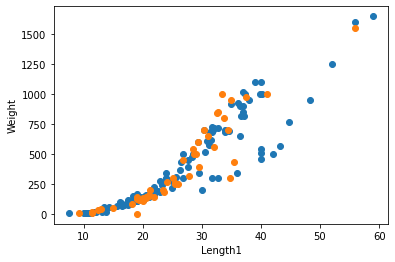

In [ ]:
plt.scatter(x_train_poly, y_train_poly)
plt.scatter(x_test_poly, y_test_poly)
plt.xlabel("Length1")
plt.ylabel("Weight")

**Width also appears to have a good polynomial relation with weight.**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.0, 100000.0)

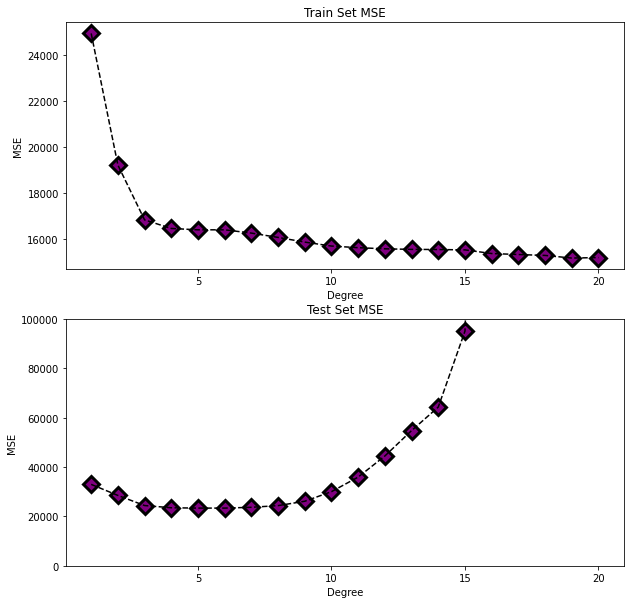

In [ ]:
x_train_poly, x_test_poly, y_train_poly, y_test_poly = train_test_split(fish['Width'], fish['Weight'], test_size = 0.3, random_state = 1)

train_mse = []
test_mse = []
model = 20
fig, axs = plt.subplots(2,1,figsize = (10,10))
axs[0].set_title("Train Set MSE")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("MSE")
axs[0].set_xticks([0,5,10,15,20])

axs[1].set_title("Test Set MSE")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("MSE")
axs[1].set_xticks([0,5,10,15,20])

for i in range(0,model):
  p = np.poly1d(np.polyfit(x_train_poly,y_train_poly,i+1))
  y_train_pred = np.polyval(p,x_train_poly)
  y_test_pred = np.polyval(p,x_test_poly)
  train_mse.append(mean_squared_error(y_train_pred,y_train_poly))
  test_mse.append(mean_squared_error(y_test_pred,y_test_poly))

  axs[0].plot(i+1,
                mean_squared_error(y_train_pred,y_train_poly),
                color = 'purple',
                label = "deg: {}".format(i+1),
                marker = 'D',
                markersize = 12,
                markeredgecolor = 'black',
                markeredgewidth = 3)

  axs[1].plot(i+1,
                mean_squared_error(y_test_pred,y_test_poly),
                color = 'purple',
                label = "deg: {}".format(i+1),
                marker = 'D',
                markersize = 12,
                markeredgecolor = 'black',
                markeredgewidth = 3)

axs[0].plot(range(1,21), train_mse, 'k--')
axs[1].plot(range(1,21), test_mse, 'k--')
axs[1].set_ylim([0,100000])

**Degree 5 appears to capture the trend of the data. The outliers presented by the pike species similarly throw off the polynomial models.**

In [ ]:
p5 = np.poly1d(np.polyfit(x_train_poly,y_train_poly,5))
print("The test set r squared is:", r2_score(p5(x_test_poly),y_test_poly))
print("The train set r squared is:", r2_score(p5(x_train_poly),y_train_poly))

The test set r squared is: 0.7735344871438355
The train set r squared is: 0.8570015452145667


Text(0, 0.5, 'Weight')

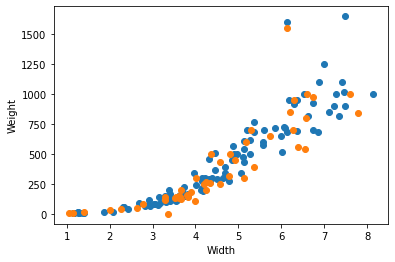

In [ ]:
plt.scatter(x_train_poly, y_train_poly)
plt.scatter(x_test_poly, y_test_poly)
plt.xlabel("Width")
plt.ylabel("Weight")

# Regression Decision Tree

**Because multi colinearity does not affect tree regression by design, we can instead use all the features for this model.**

In [ ]:
tree_features = ['Length1','Length2','Length3','Width','Height','Bream','Parkki','Perch','Pike','Roach','Smelt','Whitefish']
treex_train, treex_test, treey_train, treey_test = train_test_split(fish[tree_features],fish['Weight'],test_size = 0.3, random_state = 1)
tree = DecisionTreeRegressor(max_depth=30, random_state=0)
tree.fit(treex_train, treey_train)
yt_train = tree.predict(treex_train)
yt_test = tree.predict(treex_test)

In [ ]:
print("The training mean squared erorr is:", mean_squared_error(yt_train, treey_train))
print("The training r squared is:", r2_score(yt_train, treey_train))
print("The test mean squared erorr is:", mean_squared_error(yt_test, treey_test))
print("The test r squared is:", r2_score(yt_test, treey_test))

The training mean squared erorr is: 0.0
The training r squared is: 1.0
The test mean squared erorr is: 4092.56125
The test r squared is: 0.9649825951093083


In [ ]:
tree_score = cross_val_score(tree, fish[tree_features], fish['Weight'], scoring = 'r2', cv =cv)
tree_error = cross_val_score(tree, fish[tree_features], fish['Weight'], scoring = 'neg_mean_squared_error', cv =cv)

In [ ]:
print(tree_score)
print(tree_error)

[0.95591417 0.98451568 0.91264757 0.94945523 0.96804809 0.96097653
 0.97177543 0.90990003]
[ -3179.5205      -2598.182       -5659.715       -7758.967
  -3632.1645      -4106.2925      -3063.5225     -19351.69526316]


([], <a list of 0 Text major ticklabel objects>)

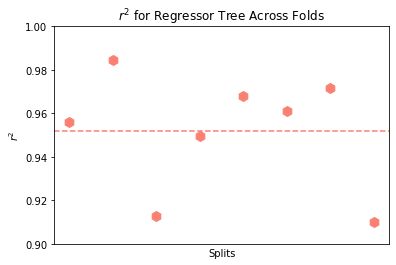

In [ ]:
plt.scatter(np.linspace(0,8,8),tree_score, marker = 'h', color = 'salmon', s = 100)
plt.axhline(np.mean(tree_score), color = 'salmon', linestyle = '--')
plt.xlabel('Splits')
plt.ylabel('$r^2$')
plt.ylim(0.9,1)
plt.title('$r^2$ for Regressor Tree Across Folds')
plt.xticks([])

**The regression tree had good performance at depth of 30. Now lets compare it to the transformed ridge model**.

([], <a list of 0 Text major ticklabel objects>)

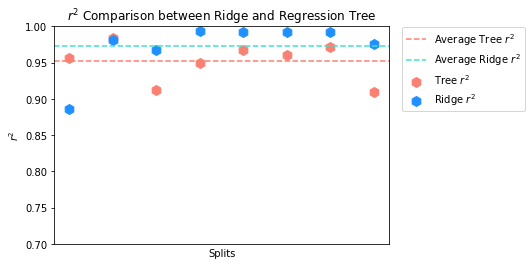

In [ ]:
plt.scatter(np.linspace(0,8,8),tree_score, marker = 'h', color = 'salmon', s = 100)
plt.scatter(np.linspace(0,8,8),ridge_score_trans, color = 'dodgerblue', s = 100, marker = 'h')
plt.axhline(np.mean(tree_score), color = 'salmon', linestyle = '--')
plt.axhline(y = np.mean(ridge_score_trans), color = 'turquoise', linestyle = '--')
plt.legend(["Average Tree $r^2$", "Average Ridge $r^2$", "Tree $r^2$", "Ridge $r^2$"], loc='upper right', bbox_to_anchor=(1.42, 1.02))
plt.xlabel('Splits')
plt.ylabel('$r^2$')
plt.ylim(0.7,1)
plt.title('$r^2$ Comparison between Ridge and Regression Tree')
plt.xticks([])

**What are the most important features?**

Text(0.5, 1.0, 'Regression Decision Tree Feature Importance')

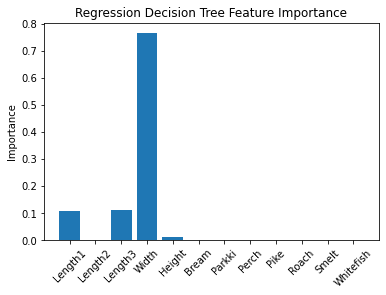

In [ ]:
importance  = np.reshape(np.array(tree.feature_importances_),(-1,1))
plt.bar(tree_features, tree.feature_importances_, width = 0.8)
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.title("Regression Decision Tree Feature Importance")

# Regression Random Forest

**First look for optimal depth for random forest using Cross Validation.**

Text(0, 0.5, '$r^2$')

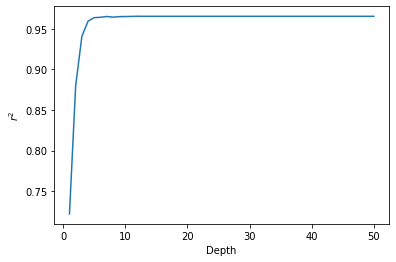

In [ ]:
mean_forest_score = []
for i in range(1,51):
  forest = RandomForestRegressor(max_depth = i, random_state = 0)
  forest.fit(treex_train,treey_train)
  forest_score = cross_val_score(forest, fish[tree_features], fish['Weight'], scoring = 'r2', cv =cv)
  mean_forest_score.append(np.mean(forest_score))
plt.plot(np.linspace(1,len(mean_forest_score), len(mean_forest_score)), mean_forest_score)
plt.xlabel("Depth")
plt.ylabel("$r^2$")

**At around 10 depth the r squared becomes stable, with minimal shift.**

In [ ]:
forest = RandomForestRegressor(max_depth = 10, random_state = 0)
forest.fit(treex_train,treey_train)
forest_score = cross_val_score(forest, fish[tree_features], fish['Weight'], scoring = 'r2', cv =cv)
forest_error = cross_val_score(forest, fish[tree_features], fish['Weight'], scoring = 'neg_mean_squared_error', cv =cv)

In [ ]:
print(forest_score)
print(forest_error)

[0.94928908 0.98262017 0.92730972 0.97471201 0.98830018 0.98442132
 0.98176173 0.93322122]
[ -3657.32961234  -2916.23958436  -4709.72891622  -3881.87843343
  -1329.98837271  -1639.28597889  -1979.59963431 -14342.76353515]


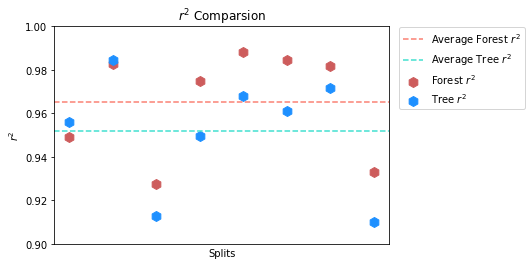

In [ ]:
plt.scatter(np.linspace(0,8,8),forest_score, marker = 'h', color = 'indianred', s = 100)
plt.axhline(np.mean(forest_score), color = 'salmon', linestyle = '--')
plt.scatter(np.linspace(0,8,8),tree_score, marker = 'h', color = 'dodgerblue', s = 100)
plt.axhline(np.mean(tree_score), color = 'turquoise', linestyle = '--')
plt.xlabel('Splits')
plt.ylabel('$r^2$')
plt.ylim(0.9,1)
plt.title('$r^2$ Comparsion')
plt.xticks([])
plt.legend(['Average Forest $r^2$', 'Average Tree $r^2$', 'Forest $r^2$', 'Tree $r^2$'], loc='upper right', bbox_to_anchor=(1.42, 1.02))

Text(0.5, 1.0, 'Regression Decision Tree Feature Importance')

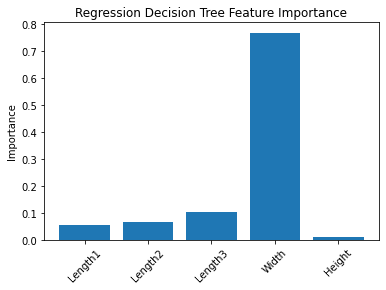

In [ ]:
importance  = np.reshape(np.array(forest.feature_importances_),(-1,1))
plt.bar(tree_features[0:5], forest.feature_importances_[0:5], width = 0.8)
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.title("Regression Random Forest Feature Importance")

# Comparison of All Models $R^2$ Values

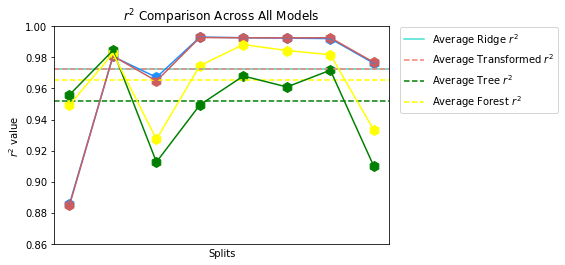

In [ ]:
plt.scatter(np.linspace(0,8,8),ridge_score_trans, color = 'dodgerblue', s = 100, marker = 'h')
plt.axhline(y = np.mean(ridge_score_trans), color = 'turquoise', linestyle = '-')
plt.scatter(np.linspace(0,8,8), score_trans, color = 'indianred', s = 100, marker = 'h')
plt.axhline(y = np.mean(score_trans), color = 'salmon', linestyle = '--')
plt.scatter(np.linspace(0,8,8),tree_score, marker = 'h', color = 'green', s = 100)
plt.scatter(np.linspace(0,8,8),forest_score, color = 'yellow', s = 100, marker = 'h')
plt.axhline(np.mean(tree_score), color = 'green', linestyle = '--')
plt.axhline(y = np.mean(forest_score), color = 'yellow', linestyle = '--')

plt.plot(np.linspace(0,8,8),ridge_score_trans, color = 'dodgerblue')
plt.plot(np.linspace(0,8,8), score_trans, color = 'indianred')
plt.plot(np.linspace(0,8,8),tree_score, marker = 'h', color = 'green')
plt.plot(np.linspace(0,8,8),forest_score, color = 'yellow')


plt.xlabel("Splits")
plt.ylabel("$r^2$ value")
plt.ylim(0.86,1)
plt.title("$r^2$ Comparison Across All Models")
plt.xticks([])
plt.legend(["Average Ridge $r^2$", "Average Transformed $r^2$", "Average Tree $r^2$", "Average Forest $r^2$"], loc='upper right', bbox_to_anchor=(1.52, 1.02))